# ICR - Identifying Age-Related Conditions

## Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import random
import numpy as np
import os

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [5]:
#random.seed(13204942)

## Data Loader and Viewer

In [6]:
data_file = '/kaggle/input/icr-identify-age-related-conditions/train.csv'

In [7]:
df = pd.read_csv(data_file)

In [8]:
def summary(text, df):
  print(f'{text} shape: {df.shape}')
  summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
  summ['null'] = df.isnull().sum()
  summ['unique'] = df.nunique()
  summ['min'] = df.min()
  summ['median'] = df.median()
  summ['max'] = df.max()
  summ['mean'] = df.mean()
  summ['std'] = df.std()
  summ['duplicate'] = df.duplicated().sum()
  return summ

In [9]:
summary('train', df)

train shape: (617, 58)


/tmp/ipykernel_20/817636048.py:7: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  summ['median'] = df.median()
/tmp/ipykernel_20/817636048.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  summ['mean'] = df.mean()
/tmp/ipykernel_20/817636048.py:10: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  summ['st

,dtypes,null,unique,min,median,max,mean,std,duplicate
Id,object,0,617,000ff2bfdfe9,NaN,ffcca4ded3bb,NaN,NaN,0
AB,float64,0,217,0.081187,0.354659,6.161666,0.477149,0.468388,0
AF,float64,0,599,192.59328,3120.318960,28688.18766,3502.013221,2300.322717,0
AH,float64,0,227,85.200147,85.200147,1910.123198,118.624513,127.838950,0
AM,float64,0,605,3.177522,20.533110,630.51823,38.968552,69.728226,0
AR,float64,0,130,8.138688,8.138688,178.943634,10.128242,10.518877,0
AX,float64,0,427,0.699861,5.031912,38.27088,5.545576,2.551696,0
AY,float64,0,148,0.025578,0.025578,10.315851,0.060320,0.416817,0
AZ,float64,0,484,3.396778,10.461320,38.971568,10.566447,4.350645,0
BC,float64,0,259,1.2299,1.229900,1463.693448,8.053012,65.166943,0


In [10]:
#Replace null with means of the same columns
def replace_null_with_mean(df):
    fields = ['BQ','CB','CC','DU','EL','FC','FL','FS','GL']
    for value in fields:
        df.fillna(df[value].mean(),axis =1,inplace=True)
    return df

In [11]:
train_non_nan = replace_null_with_mean(df)

<AxesSubplot: xlabel='Class', ylabel='count'>

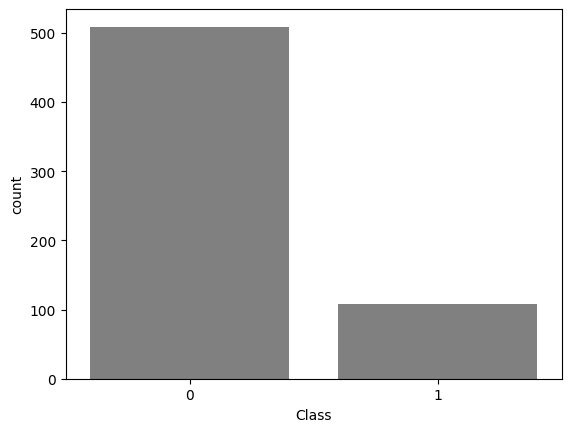

In [12]:
#Count plot for the label class
sns.countplot(train_non_nan,x='Class',color='grey')

In [13]:
train_non_nan['EJ'] = train_non_nan['EJ'].astype('category')
train = train_non_nan
train['EJ'] = train['EJ'].cat.codes
train = train.set_index('Id')

In [14]:
train.columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

In [15]:
#Creating the features and label classes
y = train['Class']
X = train.iloc[:,:-1]
y = y.astype(float)
X = X.astype(float)

Data preprocessing of the features

In [16]:
sd_scaler = preprocessing.StandardScaler()
features = sd_scaler.fit_transform(X.values)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, y.to_numpy(), test_size=0.1, random_state=42)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(555, 56)
(62, 56)
(555,)
(62,)


In [19]:
#Convert dataframes into torch tensors
def convert_to_torch(value):
  return torch.tensor(data=value,dtype=torch.float32,requires_grad=True)

In [20]:
# Dataset class
class ICRDataset(Dataset):
  def __init__(self, X_data, y_data):
    self.X_data = X_data
    self.y_data = y_data

  def __len__ (self):
    return len(self.X_data)

  def __getitem__(self, index):
    return self.X_data[index], self.y_data[index]

In [21]:
X_data = convert_to_torch(X_train)
y_data = convert_to_torch(y_train).type(torch.LongTensor)
X_val = convert_to_torch(X_test)
y_val = convert_to_torch(y_test).type(torch.LongTensor)

In [22]:
train_dataset = ICRDataset(X_data,y_data)
val_dataset = ICRDataset(X_val,y_val)

In [23]:
# Load dataloaders
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()
#NUM_WORKERS = 2

In [24]:
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    #num_workers=NUM_WORKERS,
    shuffle=True
)

val_dataloader = DataLoader(
    dataset=val_dataset, 
    batch_size=BATCH_SIZE,
    #num_workers=NUM_WORKERS,
    shuffle=False
)

## Model Builder

In [25]:
class FeedForwardNet(nn.Module):
  def __init__(self, input_features, n_classes):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(input_features,256),
        nn.LeakyReLU(negative_slope=0.1),
        nn.Dropout(p=0.5)
    )
    self.layer2 = nn.Sequential(
        nn.Linear(256,512),
        nn.LeakyReLU(negative_slope=0.1),
        nn.Dropout(p=0.5),
    )
    self.layer3 = nn.Sequential(
        nn.Linear(512,64),
        nn.LeakyReLU(negative_slope=0.1),
        nn.Dropout(p=0.5),
    )
    self.layer4 = nn.Sequential(
        nn.Linear(64,64),
        nn.LeakyReLU(negative_slope=0.1),
    )    
    self.classifier = nn.Linear(in_features=64, out_features=n_classes)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    logits = self.classifier(x)
    #probs = F.softmax(logits, dim=1)
    #probs = F.sigmoid(logits)

    return logits

In [26]:
#from torchsummary import summary

In [27]:
num_class = len(np.unique(df.Class))
input_features = X_train.shape[1]

In [28]:
#model_LeCun = LeCunNet(num_class).to(DEVICE)
model_FF = FeedForwardNet(input_features,num_class).to(DEVICE)

In [29]:
# Check model structure and parameters
#print(summary(model_LeCun, (1, 56, 56)))
#print(summary(model_FF, (1, 56, 56)))
print(model_FF)

FeedForwardNet(
  (layer1): Sequential(
    (0): Linear(in_features=56, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.5, inplace=False)
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [30]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Start Training

In [31]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 15 # 5 warm-up

PIN_MEMORY = True
LOAD_MODEL = False

In [32]:
#model = model_LeCun.to(DEVICE)
model = model_FF.to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [33]:
from tqdm import tqdm
from typing import Tuple, Dict, List

In [34]:
for X, y in train_dataloader:
  y_pred = model(X)
  loss = F.cross_entropy(X,y)
  acc = accuracy(y_pred, y)
  print(loss.item(), acc.item())
  break

4.402580738067627 1.0


In [35]:
def train_func(model, 
               train_dataloader, 
               valid_dataloader, 
               optimizer,
               loss_fn,
               epochs,
               device='cpu') -> Dict[str, List[float]]:
    
    # Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "valid_loss": [],
        "valid_acc": []
    }

    # Loop through training and validation steps for a number of epochs
    for epoch in tqdm(range(epochs)):
      # Put model in train mode
      model.train()
    
      # Setup train loss and train accuracy values
      train_loss, train_acc = 0, 0
    
      # Loop through data loader data batches
      for X, y in train_dataloader:
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        #train_acc += (y_pred_class == y[:,1].type(torch.int64)).sum().item()/len(y_pred)
        train_acc += accuracy(y_pred, y).item()

      # Adjust metrics to get average loss and accuracy per batch 
      train_loss = train_loss / len(train_dataloader)
      train_acc = train_acc / len(train_dataloader)

      # Put model in eval mode
      model.eval() 
      valid_pred = []
      valid_true = []
  
      # Setup valid loss and valid accuracy values
      valid_loss, valid_acc = 0, 0
  
      # Turn on inference context manager
      with torch.inference_mode():
        # Loop through DataLoader batches
        for X, y in valid_dataloader:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          valid_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(valid_pred_logits, y)
          valid_loss += loss.item()

          # Calculate and accumulate accuracy
          #valid_pred_labels = valid_pred_logits.type(torch.int64)
          #valid_pred_labels = torch.argmax(torch.softmax(valid_pred_logits, dim=1), dim=1)
          #valid_pred.extend(valid_pred_labels)
          
          #y = y[:,1].type(torch.int64)

          #valid_acc += ((valid_pred_labels == y).sum().item()/len(valid_pred_labels))
          valid_acc += accuracy(valid_pred_logits, y).item()

          valid_true.extend(y)
          
      # Adjust metrics to get average loss and accuracy per batch 
      valid_loss = valid_loss / len(valid_dataloader)
      valid_acc = valid_acc / len(valid_dataloader)    

      # Print out what's happening
      print(f"Epoch: {epoch+1} | ",
            f"train_loss: {train_loss:.4f} | ",
            f"train_acc: {train_acc:.4f} | ",
            f"valid_loss: {valid_loss:.4f} | ",
            f"valid_acc: {valid_acc:.4f}"
            )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["valid_loss"].append(valid_loss)
      results["valid_acc"].append(valid_acc)

    # Return the filled results at the end of the epochs
    return results, valid_true, valid_pred

In [36]:
# start training
results, y_true, y_pred = train_func(model = model, 
                                     train_dataloader = train_dataloader, 
                                     valid_dataloader = val_dataloader, 
                                     optimizer = optimizer,
                                     loss_fn = loss_fn,
                                     epochs = NUM_EPOCHS,
                                     device = DEVICE)

 13%|█▎        | 2/15 [00:00<00:02,  4.62it/s]

Epoch: 1 |  train_loss: 0.6279 |  train_acc: 0.8286 |  valid_loss: 0.6051 |  valid_acc: 0.7969
Epoch: 2 |  train_loss: 0.5473 |  train_acc: 0.8274 |  valid_loss: 0.5372 |  valid_acc: 0.7969


 27%|██▋       | 4/15 [00:00<00:02,  4.88it/s]

Epoch: 3 |  train_loss: 0.4843 |  train_acc: 0.8304 |  valid_loss: 0.4936 |  valid_acc: 0.7969
Epoch: 4 |  train_loss: 0.4415 |  train_acc: 0.8304 |  valid_loss: 0.4638 |  valid_acc: 0.7969


 40%|████      | 6/15 [00:01<00:01,  5.06it/s]

Epoch: 5 |  train_loss: 0.4216 |  train_acc: 0.8244 |  valid_loss: 0.4388 |  valid_acc: 0.7969
Epoch: 6 |  train_loss: 0.3825 |  train_acc: 0.8304 |  valid_loss: 0.4182 |  valid_acc: 0.7969


 47%|████▋     | 7/15 [00:01<00:01,  5.05it/s]

Epoch: 7 |  train_loss: 0.3705 |  train_acc: 0.8244 |  valid_loss: 0.3959 |  valid_acc: 0.8125


 60%|██████    | 9/15 [00:01<00:01,  4.82it/s]

Epoch: 8 |  train_loss: 0.3298 |  train_acc: 0.8393 |  valid_loss: 0.3765 |  valid_acc: 0.8750
Epoch: 9 |  train_loss: 0.3160 |  train_acc: 0.8679 |  valid_loss: 0.3478 |  valid_acc: 0.8594


 73%|███████▎  | 11/15 [00:02<00:00,  4.97it/s]

Epoch: 10 |  train_loss: 0.2856 |  train_acc: 0.8768 |  valid_loss: 0.3364 |  valid_acc: 0.8594
Epoch: 11 |  train_loss: 0.2824 |  train_acc: 0.8845 |  valid_loss: 0.3207 |  valid_acc: 0.8594


 87%|████████▋ | 13/15 [00:02<00:00,  5.05it/s]

Epoch: 12 |  train_loss: 0.2568 |  train_acc: 0.9089 |  valid_loss: 0.3184 |  valid_acc: 0.8542
Epoch: 13 |  train_loss: 0.2449 |  train_acc: 0.9071 |  valid_loss: 0.3145 |  valid_acc: 0.8542


100%|██████████| 15/15 [00:03<00:00,  4.94it/s]

Epoch: 14 |  train_loss: 0.2498 |  train_acc: 0.9089 |  valid_loss: 0.3203 |  valid_acc: 0.8542
Epoch: 15 |  train_loss: 0.2365 |  train_acc: 0.9131 |  valid_loss: 0.3235 |  valid_acc: 0.8542


Plotting the looses

Text(0.5, 1.0, 'Loss vs. No. of epochs')

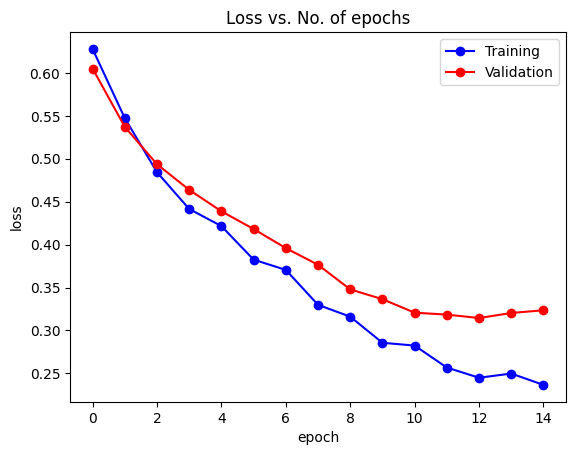

In [37]:
""" Plot the losses in each epoch"""
train_losses = results.get('train_loss')
val_losses = results.get('valid_loss')
plt.plot(train_losses, '-bo')
plt.plot(val_losses, '-ro')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')

Save the model

In [38]:
#torch.save(model,'./ICRClassifier.pt')

Load the Model

In [39]:
#model_test = torch.load('./ICRClassifier.pt')
model_test = model
model_test.to(DEVICE)

FeedForwardNet(
  (layer1): Sequential(
    (0): Linear(in_features=56, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.5, inplace=False)
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

Test Model on Testset

In [40]:
class ICRData_test(Dataset):
  def __init__(self, X_test_data):
    self.X_test_data = X_test_data
  
  def __getitem__(self, index):
    return self.X_test_data[index]
  
  def __len__ (self):
    return len(self.X_test_data)

In [41]:
def model_tester(model, testfile_path):
  df = pd.read_csv(testfile_path)
  test_df = df.set_index("Id")
  test_df['EJ'] = test_df['EJ'].astype('category').cat.codes
  test = test_df
  test['EJ'] = test['EJ'].astype(float)

  scaler = preprocessing.StandardScaler()
  num_cols = list(test.select_dtypes(include=['float']))
  features = scaler.fit_transform(test.values)


  testing_data = ICRData_test(convert_to_torch(features))
  test_dataloader = DataLoader(testing_data, batch_size=1, shuffle=False)
  
  model.eval()
  Ids = np.empty(shape=(len(test),), dtype=object)
  Class_0 = np.empty(shape=(len(test),))
  Class_1 = np.empty(shape=(len(test),))
  
  with torch.no_grad():
      for i,features in tqdm(enumerate(test_dataloader)):
          output = model(features)
          probs=F.softmax(output, dim=1).squeeze().detach().cpu().numpy()   
          Class_0[i] = probs[0]
          Class_1[i] = probs[1]
          print(test.index[i])
          Ids[i] = test.index[i]
          

  submission = pd.DataFrame(data={"Id" : Ids, "class_0" : Class_0, "class_1" : Class_1})
  print("Prediction Completed")
  return submission

In [42]:
test_df =  model_tester(model_test, '/kaggle/input/icr-identify-age-related-conditions/test.csv')

5it [00:00, 1094.03it/s]

00eed32682bb
010ebe33f668
02fa521e1838
040e15f562a2
046e85c7cc7f
Prediction Completed


In [43]:
test_df

,Id,class_0,class_1
0,00eed32682bb,0.771845,0.228155
1,010ebe33f668,0.771845,0.228155
2,02fa521e1838,0.771845,0.228155
3,040e15f562a2,0.771845,0.228155
4,046e85c7cc7f,0.771845,0.228155


Save the results

In [44]:
test_df.to_csv("./submission.csv", index=False)
print("Submission Completed")

Submission Completed
